In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

sys.path.insert(0, '/home/sharifullina/thesis/Soft-DTW-Loss/')
from sdtw_cuda_loss import SoftDTW

In [3]:
# %load_ext tensorboard
# from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda:1') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/datasets/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Преобразуем данные

In [6]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [7]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])
    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [47]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


# training
# from training.train_verification import tsfresh_metrics

### Загрузим датасет

In [9]:
torch_dataset = DataSet(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [10]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### Train verification model

In [16]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)
criterion_verification = nn.CrossEntropyLoss()

Epoch: 1, Train loss: 2.959, Val loss: 2.807, Train acc: 0.095, Val acc: 0.134, 
Epoch: 11, Train loss: 2.319, Val loss: 2.285, Train acc: 0.268, Val acc: 0.288, 
Epoch: 21, Train loss: 2.126, Val loss: 2.069, Train acc: 0.321, Val acc: 0.338, 
Epoch: 31, Train loss: 2.0, Val loss: 2.028, Train acc: 0.362, Val acc: 0.365, 
Epoch: 41, Train loss: 1.909, Val loss: 1.924, Train acc: 0.388, Val acc: 0.393, 
Epoch: 51, Train loss: 1.762, Val loss: 1.725, Train acc: 0.438, Val acc: 0.464, 
Epoch: 61, Train loss: 1.614, Val loss: 1.629, Train acc: 0.482, Val acc: 0.53, 
Epoch: 71, Train loss: 1.488, Val loss: 1.476, Train acc: 0.519, Val acc: 0.543, 
Epoch: 81, Train loss: 1.431, Val loss: 1.435, Train acc: 0.537, Val acc: 0.552, 
Epoch: 91, Train loss: 1.356, Val loss: 1.364, Train acc: 0.556, Val acc: 0.597, 
Best_train_acc: 0.5900188088417053, Best_val_acc: 0.6175972819328308, 


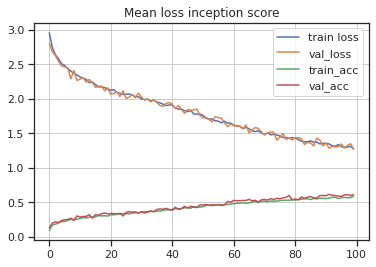

In [17]:
best_train_acc = 0
best_val_acc = 0
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = np.inf
patience_counter = 0
best_state_dict = None

for epoch in range(num_epochs):
    model_verification.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for x_t, y_t in train_loader:
        x_t = x_t.to(device)
        y_t = y_t.to(device)
        optimizer_verification.zero_grad()
        output = model_verification(x_t)
        loss = criterion_verification(output, y_t)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer_verification.step()
        _, preds = torch.max(output, 1)
        all_preds.append(preds)
        all_y.append(y_t)
    train_loss.append(np.mean(epoch_train_loss))
    train_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    
    train_acc_now = float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy())
    if best_train_acc < train_acc_now:
        best_train_acc = train_acc_now
    
    epoch_val_loss = []
    model_verification.eval()
    all_preds = []
    all_y = []
    for x_v, y_v in val_loader:
        x_v = x_v.to(device)
        y_v = y_v.to(device)
        with torch.no_grad():
            output = model_verification(x_v)
            loss = criterion_verification(output, y_v)
            epoch_val_loss.append(loss.item())
            _, preds = torch.max(output, 1)
            all_preds.append(preds)
            all_y.append(y_v)
    val_loss.append(np.mean(epoch_val_loss))
    val_acc.append(float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy()))
    
    val_acc_now = float((torch.cat(all_preds) == torch.cat(all_y)).float().mean().cpu().data.numpy())
    if best_val_acc < val_acc_now:
        best_val_acc = val_acc_now
    if epoch % 10 == 0:
        print(f'Epoch: {epoch + 1}, '
              f'Train loss: {round(train_loss[-1], 3)}, '
              f'Val loss: {round(val_loss[-1], 3)}, '
              f'Train acc: {round(train_acc[-1], 3)}, '
              f'Val acc: {round(val_acc[-1], 3)}, ')
    
print(f'Best_train_acc: {best_train_acc}, '
      f'Best_val_acc: {best_val_acc}, ')

plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val_loss')
plt.plot(train_acc, label = 'train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.legend()
plt.grid()
plt.title('Mean loss inception score')
plt.show()

torch.save({
    'model_state_dict': model_verification.state_dict(),
    'best_train_acc': best_train_acc,
    'best_val_acc': best_val_acc}, 
    'trained_models/model_verification.pt'
)

In [18]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])
best_train_acc = checkpoint['best_train_acc']
best_val_acc = checkpoint['best_val_acc']
# model_verification.eval()

### Regulator
Создадим словарь, где ключами будут [функция потерь регулятора], а значениями функция лоса регулятора, генератора и дискриминатора

In [19]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
             'SSIM_1d_conv']

regul_loss_dict = dict.fromkeys(reg_names, [])
# regul_loss_list = [Mean_similarity_loss, 
#                    Root_mean_square_similarity_loss, 
#                    Coisine_between_angles_loss,
#                    Pearson_corr_funct_loss, 
#                    Eucledian_distance_loss, 
#                    SSIM_1d_conv]


In [20]:
regul_loss_dict

{'Mean_similarity_loss': [],
 'Root_mean_square_similarity_loss': [],
 'Coisine_between_angles_loss': [],
 'Pearson_corr_funct_loss': [],
 'Eucledian_distance_loss': [],
 'SSIM_1d_conv': []}

### Training models

In [21]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)

In [22]:
disc_ms = Discriminator().to(device)
gen_ms = Generator().to(device)

disc_rms = Discriminator().to(device)
gen_rms = Generator().to(device)

disc_cba = Discriminator().to(device)
gen_cba = Generator().to(device)

disc_pcf = Discriminator().to(device)
gen_pcf = Generator().to(device)

disc_ed = Discriminator().to(device)
gen_ed = Generator().to(device)

disc_ssim = Discriminator().to(device)
gen_ssim = Generator().to(device)

criterion_gan_ms = nn.BCELoss()
criterion_gan_rms = nn.BCELoss()
criterion_gan_cba = nn.BCELoss()
criterion_gan_pcf = nn.BCELoss()
criterion_gan_ed = nn.BCELoss()
criterion_gan_ssim = nn.BCELoss()

D_opt_ms = torch.optim.Adam(disc_ms.parameters(), lr = lr)
G_opt_ms = torch.optim.Adam(gen_ms.parameters(), lr = lr)

D_opt_rms = torch.optim.Adam(disc_rms.parameters(), lr = lr)
G_opt_rms = torch.optim.Adam(gen_rms.parameters(), lr = lr)

D_opt_cba = torch.optim.Adam(disc_cba.parameters(), lr = lr)
G_opt_cba = torch.optim.Adam(gen_cba.parameters(), lr = lr)

D_opt_pcf = torch.optim.Adam(disc_pcf.parameters(), lr = lr)
G_opt_pcf = torch.optim.Adam(gen_pcf.parameters(), lr = lr)

D_opt_ed = torch.optim.Adam(disc_ed.parameters(), lr = lr)
G_opt_ed = torch.optim.Adam(gen_ed.parameters(), lr = lr)

D_opt_ssim = torch.optim.Adam(disc_ssim.parameters(), lr = lr)
G_opt_ssim = torch.optim.Adam(gen_ssim.parameters(), lr = lr)

In [23]:
# print('Discriminator paramteres:', sum(p.numel() for p in disc_mean_similarity.parameters() if p.requires_grad))
# print('Generator paramteres:', sum(p.numel() for p in gen_mean_similarity.parameters() if p.requires_grad))

In [24]:
# writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
# writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

### training the model

In [81]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate = 0
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)
            noise = torch.randn(real_data.size(0), len(required_params), real_data.size(2), device=device)

            # Generator training
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(noise)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

            # verificator loss
            model_verification.eval()
            output_class = model_verification(real_data)
            loss_verif = criterion_verification(output_class, y)
            V_losses.append(loss_verif.item())
            preds = torch.argmax(output_class, 1)
            verificator_labels.append(y)
            verificator_preds.append(preds)

            # similarity loss
#             criterion_regulator = criterion_regulator().to(device)
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())

            # Discriminator training
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(noise)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))

            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif.detach() + loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss:.4f}, Loss G: {G_loss:.4f}, Loss V: {loss_verif:.4f}, Loss R: {loss_regul:.4f},")

            step += 1

        verif_acc = float((torch.cat(verificator_preds) == torch.cat(verificator_labels)).float().mean().cpu().data.numpy()) / best_train_acc

        if de_ident_rate < verif_acc:
            de_ident_rate = verif_acc
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, str_simil: {1 - loss_regul.item():.4f}, verif_acc: {verif_acc:.4f}")
        
            
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': 1 - loss_regul.item()}, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses

---

### models training

In [26]:
losses_ms = train(loader = train_loader, 
                  gen = gen_ms, 
                  disc = disc_ms, 
                  criterion_gan = criterion_gan_ms, 
                  G_opt = G_opt_ms, 
                  D_opt = D_opt_ms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.5021, Loss G: 0.5206, Loss V: 1.3822, Loss R: 0.2487,
Epoch 0, str_simil: 0.7513, de_ident_rate: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 0.3762, Loss G: 0.0268, Loss V: 1.3081, Loss R: 0.2445,
Epoch 10, str_simil: 0.7555, de_ident_rate: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 0.3280, Loss G: 0.0132, Loss V: 1.3158, Loss R: 0.1961,
Epoch 20, str_simil: 0.8039, de_ident_rate: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 0.2880, Loss G: 0.0041, Loss V: 1.1061, Loss R: 0.1772,
Epoch 30, str_simil: 0.8228, de_ident_rate: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 0.3116, Loss G: 0.0005, Loss V: 1.2688, Loss R: 0.1847,
Epoch 40, str_simil: 0.8153, de_ident_rate: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 0.3114, Loss G: 0.0001, Loss V: 1.1834, Loss R: 0.1925,
Epoch 50, str_simil: 0.8075, de_ident_rate: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 0.3059, Loss G: 0.0004, Loss V: 1.1235, Loss R: 0.1934,
Epoch 60, str_simil: 0.8066, de_ident_rate: 1.0243
Epoch [7

In [27]:
gen_ms = Generator().to(device)
disc_ms = Discriminator().to(device)

checkpoint_ms = torch.load('trained_models/gan_ms.pt')

gen_ms.load_state_dict(checkpoint_ms['gen_state_dict'])
disc_ms.load_state_dict(checkpoint_ms['disc_state_dict'])
de_ident_rate_ms = checkpoint_ms['de_ident_rate']
str_simil_ms = checkpoint_ms['str_simil']

# gen_ms.eval()

### root_mean_square

In [28]:
losses_rms = train(loader = train_loader, 
                  gen = gen_rms, 
                  disc = disc_rms, 
                  criterion_gan = criterion_gan_rms, 
                  G_opt = G_opt_rms, 
                  D_opt = D_opt_rms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.6615, Loss G: 0.2087, Loss V: 1.2444, Loss R: 0.4181,
Epoch 0, str_simil: 0.5819, de_ident_rate: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 0.4468, Loss G: 0.0431, Loss V: 0.9533, Loss R: 0.3499,
Epoch 10, str_simil: 0.6501, de_ident_rate: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 0.4573, Loss G: 0.0035, Loss V: 1.2261, Loss R: 0.3345,
Epoch 20, str_simil: 0.6655, de_ident_rate: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 0.4688, Loss G: 0.0016, Loss V: 1.2378, Loss R: 0.3449,
Epoch 30, str_simil: 0.6551, de_ident_rate: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 0.4816, Loss G: 0.0009, Loss V: 1.2443, Loss R: 0.3562,
Epoch 40, str_simil: 0.6438, de_ident_rate: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 0.4687, Loss G: 0.0036, Loss V: 1.3451, Loss R: 0.3341,
Epoch 50, str_simil: 0.6659, de_ident_rate: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 0.4353, Loss G: 0.0009, Loss V: 1.0824, Loss R: 0.3270,
Epoch 60, str_simil: 0.6730, de_ident_rate: 1.0243
Epoch [7

In [31]:
gen_rms = Generator().to(device)
disc_rms = Discriminator().to(device)

checkpoint_rms = torch.load('trained_models/gan_rms.pt')

gen_rms.load_state_dict(checkpoint_rms['gen_state_dict'])
disc_rms.load_state_dict(checkpoint_rms['disc_state_dict'])
de_ident_rate_rms = checkpoint_rms['de_ident_rate']
str_simil_rms = checkpoint_rms['str_simil']

# gen_rms.eval()

### coisine_between_angles

In [32]:
losses_cba = train(loader = train_loader, 
                  gen = gen_cba, 
                  disc = disc_cba, 
                  criterion_gan = criterion_gan_cba, 
                  G_opt = G_opt_cba, 
                  D_opt = D_opt_cba, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Coisine_between_angles_loss,
                  save_PATH = 'trained_models/gan_cba.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.1956, Loss G: 0.1765, Loss V: 1.1183, Loss R: 0.0032,
Epoch 0, str_simil: 0.9968, verif_acc: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 0.1221, Loss G: 0.0057, Loss V: 1.2018, Loss R: 0.0012,
Epoch 10, str_simil: 0.9988, verif_acc: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 0.1620, Loss G: 0.0013, Loss V: 1.6145, Loss R: 0.0003,
Epoch 20, str_simil: 0.9997, verif_acc: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 0.1105, Loss G: 0.0000, Loss V: 1.0996, Loss R: 0.0004,
Epoch 30, str_simil: 0.9996, verif_acc: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 0.1245, Loss G: 0.0004, Loss V: 1.2302, Loss R: 0.0014,
Epoch 40, str_simil: 0.9986, verif_acc: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 0.1190, Loss G: 0.0005, Loss V: 1.1825, Loss R: 0.0007,
Epoch 50, str_simil: 0.9993, verif_acc: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 0.1218, Loss G: 0.0003, Loss V: 1.1995, Loss R: 0.0018,
Epoch 60, str_simil: 0.9982, verif_acc: 1.0243
Epoch [70/100] Batch 82/83 Loss D: 0

In [35]:
gen_cba = Generator().to(device)
disc_cba = Discriminator().to(device)

checkpoint_cba = torch.load('trained_models/gan_cba.pt')

gen_cba.load_state_dict(checkpoint_cba['gen_state_dict'])
disc_cba.load_state_dict(checkpoint_cba['disc_state_dict'])
de_ident_rate_cba = checkpoint_cba['de_ident_rate']
str_simil_cba = checkpoint_cba['str_simil']

### pearson_corr_funct

In [36]:
losses_pcf = train(loader = train_loader, 
                  gen = gen_pcf, 
                  disc = disc_pcf, 
                  criterion_gan = criterion_gan_pcf, 
                  G_opt = G_opt_pcf, 
                  D_opt = D_opt_pcf, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Pearson_corr_funct_loss,
                  save_PATH = 'trained_models/gan_pcf.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.2536, Loss G: 0.1530, Loss V: 1.3084, Loss R: 0.0037,
Epoch 0, str_simil: 0.9963, verif_acc: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 0.1166, Loss G: 0.0236, Loss V: 1.1509, Loss R: 0.0006,
Epoch 10, str_simil: 0.9994, verif_acc: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 0.1111, Loss G: 0.0064, Loss V: 1.1147, Loss R: -0.0008,
Epoch 20, str_simil: 1.0008, verif_acc: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 0.1206, Loss G: 0.0007, Loss V: 1.1959, Loss R: 0.0007,
Epoch 30, str_simil: 0.9993, verif_acc: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 0.1379, Loss G: 0.0013, Loss V: 1.3690, Loss R: 0.0009,
Epoch 40, str_simil: 0.9991, verif_acc: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 0.1111, Loss G: 0.0022, Loss V: 1.1052, Loss R: 0.0006,
Epoch 50, str_simil: 0.9994, verif_acc: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 0.1122, Loss G: 0.0008, Loss V: 1.0775, Loss R: 0.0045,
Epoch 60, str_simil: 0.9955, verif_acc: 1.0243
Epoch [70/100] Batch 82/83 Loss D: 

In [53]:
gen_pcf = Generator().to(device)
disc_pcf = Discriminator().to(device)

checkpoint_pcf = torch.load('trained_models/gan_pcf.pt')

gen_pcf.load_state_dict(checkpoint_pcf['gen_state_dict'])
disc_pcf.load_state_dict(checkpoint_pcf['disc_state_dict'])
de_ident_rate_pcf = checkpoint_pcf['de_ident_rate']
str_simil_pcf = checkpoint_pcf['str_simil']

### eucledian_distance

In [82]:
losses_ed = train(loader = train_loader, 
                  gen = gen_ed, 
                  disc = disc_ed, 
                  criterion_gan = criterion_gan_ed, 
                  G_opt = G_opt_ed, 
                  D_opt = D_opt_ed, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Eucledian_distance_loss,
                  save_PATH = 'trained_models/gan_ed.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.0875, Loss G: 0.6791, Loss V: 1.1288, Loss R: 0.2757,
Epoch 0, str_simil: 0.7243, verif_acc: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 1.0996, Loss G: 0.6797, Loss V: 1.1063, Loss R: 0.2871,
Epoch 10, str_simil: 0.7129, verif_acc: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 1.1081, Loss G: 0.6779, Loss V: 1.0648, Loss R: 0.3026,
Epoch 20, str_simil: 0.6974, verif_acc: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 1.1971, Loss G: 0.6756, Loss V: 1.2312, Loss R: 0.3820,
Epoch 30, str_simil: 0.6180, verif_acc: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 1.1090, Loss G: 0.6810, Loss V: 1.2573, Loss R: 0.2845,
Epoch 40, str_simil: 0.7155, verif_acc: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 1.2311, Loss G: 0.6827, Loss V: 1.1504, Loss R: 0.4251,
Epoch 50, str_simil: 0.5749, verif_acc: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 1.1466, Loss G: 0.6801, Loss V: 1.3293, Loss R: 0.3168,
Epoch 60, str_simil: 0.6832, verif_acc: 1.0243
Epoch [70/100] Batch 82/83 Loss D: 1

In [83]:
gen_ed = Generator().to(device)
disc_ed = Discriminator().to(device)

checkpoint_ed = torch.load('trained_models/gan_ed.pt')

gen_ed.load_state_dict(checkpoint_ed['gen_state_dict'])
disc_ed.load_state_dict(checkpoint_ed['disc_state_dict'])
de_ident_rate_ed = checkpoint_ed['de_ident_rate']
str_simil_ed = checkpoint_ed['str_simil']

### ssim

In [50]:
losses_ssim = train(loader = train_loader, 
                    gen = gen_ssim, 
                    disc = disc_ssim, 
                    criterion_gan = criterion_gan_ssim, 
                    G_opt = G_opt_ssim, 
                    D_opt = D_opt_ssim, 
                    model_verification = model_verification, 
                    criterion_verification = criterion_verification, 
                    criterion_regulator = SSIM_1d_conv,
                    save_PATH = 'trained_models/gan_ssim.pt', 
                    lr = lr, 
                    batch_size = batch_size, 
                    num_epochs = num_epochs, 
                    n_noise = n_noise, 
                    n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.6740, Loss G: 0.2748, Loss V: 1.0903, Loss R: 0.4504,
Epoch 0, str_simil: 0.5496, verif_acc: 1.0243
Epoch [10/100] Batch 82/83 Loss D: 0.7179, Loss G: 0.0427, Loss V: 1.1301, Loss R: 0.6042,
Epoch 10, str_simil: 0.3958, verif_acc: 1.0243
Epoch [20/100] Batch 82/83 Loss D: 0.5584, Loss G: 0.0120, Loss V: 1.1861, Loss R: 0.4396,
Epoch 20, str_simil: 0.5604, verif_acc: 1.0243
Epoch [30/100] Batch 82/83 Loss D: 1.5906, Loss G: 0.0031, Loss V: 1.2332, Loss R: 1.4671,
Epoch 30, str_simil: -0.4671, verif_acc: 1.0243
Epoch [40/100] Batch 82/83 Loss D: 0.7679, Loss G: 0.0002, Loss V: 1.2063, Loss R: 0.6471,
Epoch 40, str_simil: 0.3529, verif_acc: 1.0243
Epoch [50/100] Batch 82/83 Loss D: 0.6114, Loss G: 0.0001, Loss V: 0.9690, Loss R: 0.5144,
Epoch 50, str_simil: 0.4856, verif_acc: 1.0243
Epoch [60/100] Batch 82/83 Loss D: 0.5932, Loss G: 0.0034, Loss V: 1.1897, Loss R: 0.4737,
Epoch 60, str_simil: 0.5263, verif_acc: 1.0243
Epoch [70/100] Batch 82/83 Loss D: 

In [51]:
gen_ssim = Generator().to(device)
disc_ssim = Discriminator().to(device)

checkpoint_ssim = torch.load('trained_models/gan_ssim.pt')

gen_ssim.load_state_dict(checkpoint_ssim['gen_state_dict'])
disc_ssim.load_state_dict(checkpoint_ssim['disc_state_dict'])
de_ident_rate_ssim = checkpoint_ssim['de_ident_rate']
str_simil_ssim = checkpoint_ssim['str_simil']

### Figure

In [84]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
             'SSIM_1d_conv']

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss, 
                   SSIM_1d_conv]


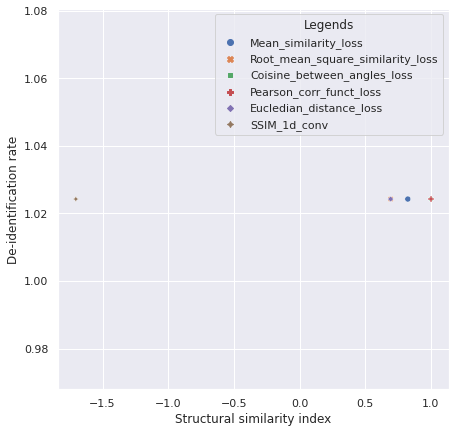

In [85]:
sns.set_theme()
data = pd.DataFrame({
    'Structural similarity index': [str_simil_ms, str_simil_rms, str_simil_cba, str_simil_pcf, str_simil_ed, str_simil_ssim],
    'De-identification rate': [de_ident_rate_ms, de_ident_rate_rms, de_ident_rate_cba, de_ident_rate_pcf, de_ident_rate_ed, de_ident_rate_ssim],
    'Legends': reg_names})

plt.figure(figsize = (7, 7))
sns.scatterplot(data=data, x="Structural similarity index", 
                y="De-identification rate", 
                hue = 'Legends', 
                style="Legends",
                legend='brief');
plt.savefig('De_iden_vs_structural_simil')


## test

In [73]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [74]:
test_well = wells[22]
test_well

'well_17.json'

In [75]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [76]:
y_name = 'DEPTH'
# X_test

In [77]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = gen_ssim(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [78]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [79]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:03<00:00, 268.70it/s]


837it [00:00, 194537.98it/s]
/tmp/ipykernel_29852/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 189497.60it/s]
/tmp/ipykernel_29852/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 197093.67it/s]
/tmp/ipykernel_29852/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 194505.65it/s]
/tmp/ipykernel_29852/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 199990.46it/s]
/tmp/ipykernel_29852/2951573407.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


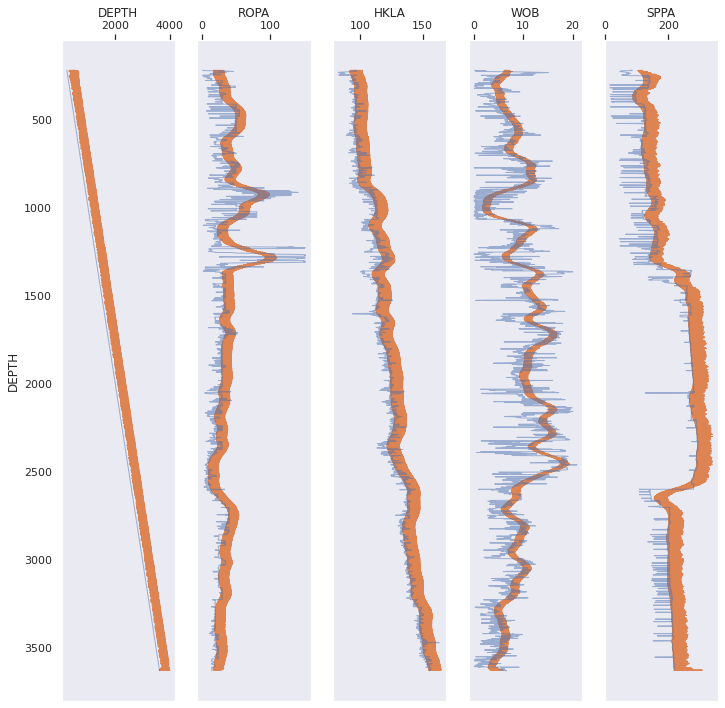

In [80]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
plt.save('')

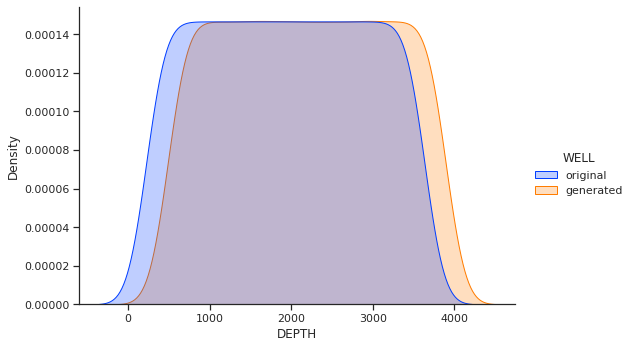

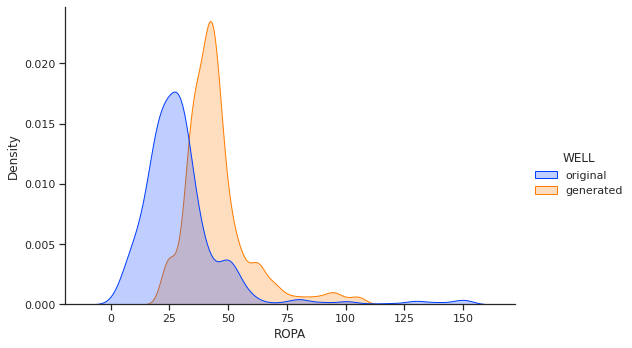

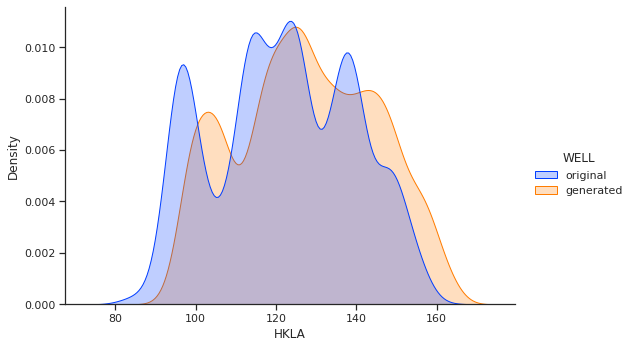

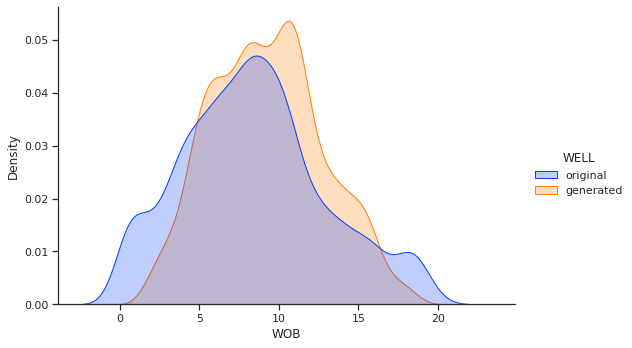

In [58]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )